## Imports

### modules

In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import cv2
import json

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters, RandomSearch



C:\Users\Chris\AppData\Local\Temp\ipykernel_24348\4119509558.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')

### data

In [3]:
dataset_path = "../../data/meta/final_dataset_labeled.csv"
image_folder_path = "../../data/images/train"
image_folder_test = "../../data/images/test"

In [4]:
df = pd.read_csv(dataset_path, index_col=0)
df

,name,car_name,car_type,is_test
1,00002_Acura TL Sedan 2012.jpg,Acura TL Sedan 2012,Midsize,0
2,00003_Dodge Dakota Club Cab 2007.jpg,Dodge Dakota Club Cab 2007,Large,0
3,00004_Hyundai Sonata Hybrid Sedan 2012.jpg,Hyundai Sonata Hybrid Sedan 2012,Midsize,0
6,00007_Dodge Journey SUV 2012.jpg,Dodge Journey SUV 2012,Midsize,1
7,00008_Dodge Charger Sedan 2012.jpg,Dodge Charger Sedan 2012,Midsize,0
...,...,...,...,...
26212,RamCVCargoVanMinivan201294.jpeg,Ram C/V Cargo Van Minivan 2012,Large,1
26213,RamCVCargoVanMinivan201296.jpeg,Ram C/V Cargo Van Minivan 2012,Large,0
26214,RamCVCargoVanMinivan201297.jpeg,Ram C/V Cargo Van Minivan 2012,Large,0
26215,RamCVCargoVanMinivan201298.jpeg,Ram C/V Cargo Van Minivan 2012,Large,0


## Prepare data

### initialize ImageDataGenerator class for data-augmentation and data splitting

In [26]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=17,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

datagen_testing = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
)



### creating the data input pipeline with the initialized ImageDataGenerator

### split data into train and validation sets

In [27]:
train_set = datagen.flow_from_directory(image_folder_path,
                                              target_size = (256, 256),
                                              color_mode = "rgb",
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

val_set = datagen.flow_from_directory(image_folder_path,
                                              target_size = (256,256),
                                              color_mode = "rgb",
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False)

test_set = datagen_testing.flow_from_directory(image_folder_test,
                                              target_size = (256,256),
                                              color_mode = "rgb",
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 14288 images belonging to 3 classes.
Found 3571 images belonging to 3 classes.
Found 1756 images belonging to 3 classes.


### data exploration of training set

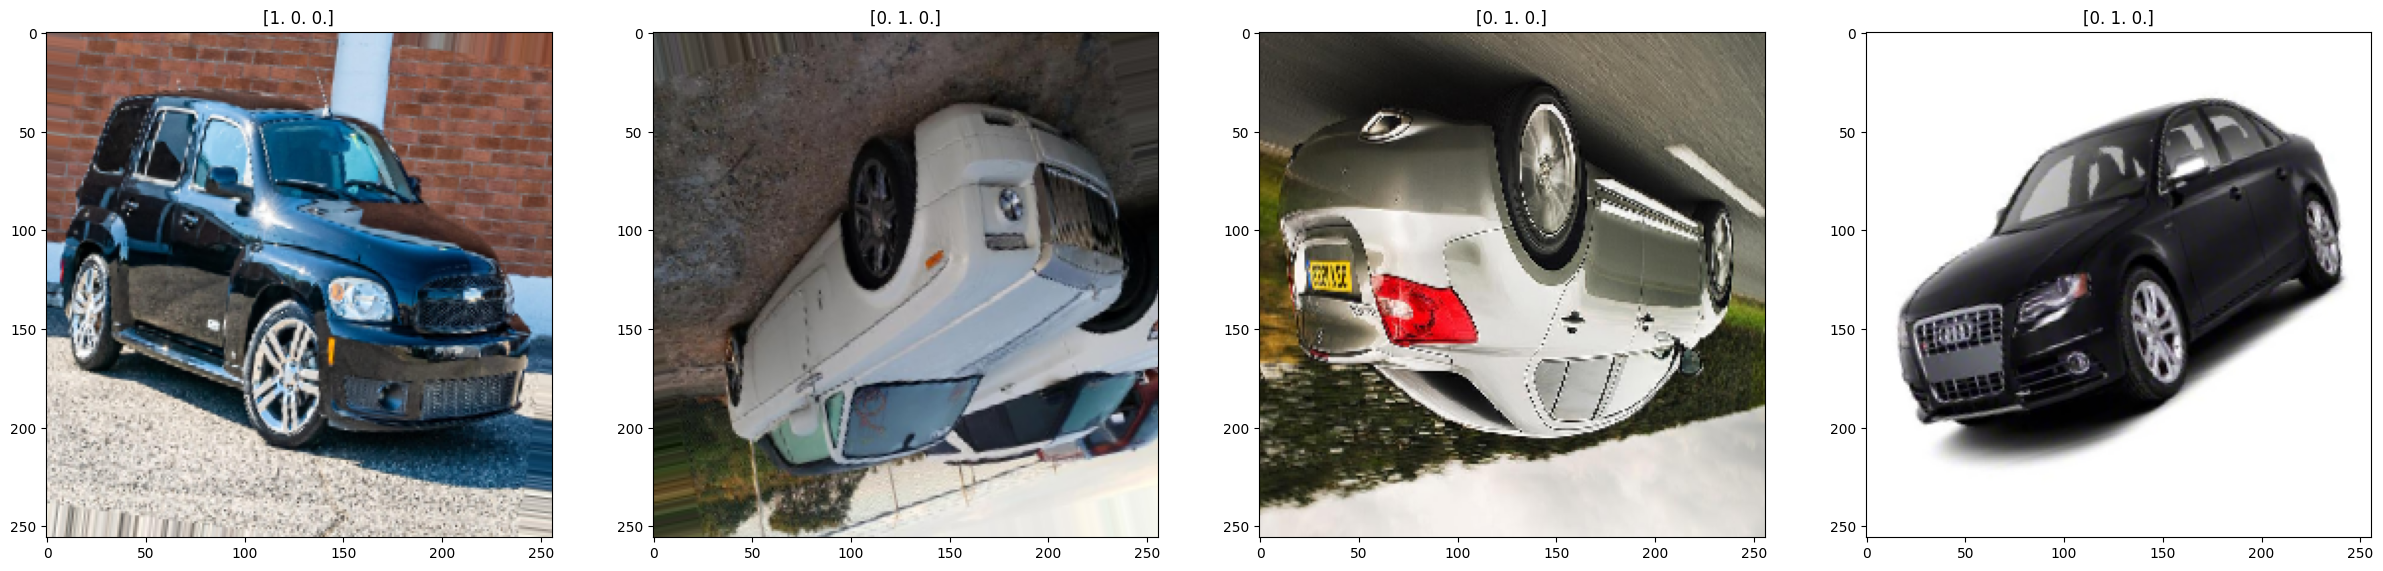

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(30, 30))
for index, image in enumerate(train_set.next()[0][:4]): 
    ax[index].imshow(image)
    ax[index].title.set_text(train_set.next()[1][index])


####  [1, 0, 0] = Large
####  [0, 1, 0] = Midsize
####  [0, 0, 1] = Small

## Building the model

### build the CNN with EfficientNet Architecture and keras tuner

In [23]:
hp = HyperParameters()
hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
hp.Choice('batch_size', values=[16, 32])
hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
hp.Int("dense_neurons", min_value=256, max_value=1024, step=128)
hp.Float("regularization_l", min_value=0.01, max_value=0.035, step=0.05)

def build_model(hp):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling='max')
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(hp.get("dense_neurons"), kernel_regularizer=tf.keras.regularizers.l2(l=hp.get("regularization_l")),
    activity_regularizer=tf.keras.regularizers.l1(hp.get("regularization_l")),
              bias_regularizer=tf.keras.regularizers.l1(hp.get("regularization_l")), activation='relu')(x)
    x = Dropout(rate=hp.get('dropout_rate'), seed=42)(x)
    output = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    optimizer = Adamax(learning_rate=hp.get('learning_rate'))
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    hyperparameters=hp,
    directory='model_params',
    project_name='car_body_params'
)

### perform the hyperparameter search and getting the best model

In [24]:
tuner.search(train_set, validation_data=val_set, epochs=20, batch_size=32)
best_hp = tuner.get_best_hyperparameters(1)[0]

Trial 10 Complete [00h 59m 09s]
val_accuracy: 0.5873104929924011

Best val_accuracy So Far: 0.8997753858566284
Total elapsed time: 09h 31m 49s
INFO:tensorflow:Oracle triggered exit


In [35]:
final_model = tuner.hypermodel.build(best_hp)
tuner.results_summary()

Results summary
Results in model_params\car_body_params
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
learning_rate: 0.0002115705594649727
batch_size: 32
dropout_rate: 0.2
dense_neurons: 512
regularization_l: 0.01
Score: 0.8997753858566284

Trial 05 summary
Hyperparameters:
learning_rate: 0.0001656118230010775
batch_size: 16
dropout_rate: 0.4
dense_neurons: 896
regularization_l: 0.01
Score: 0.883773148059845

Trial 04 summary
Hyperparameters:
learning_rate: 0.0004126407644629029
batch_size: 32
dropout_rate: 0.0
dense_neurons: 768
regularization_l: 0.01
Score: 0.880685031414032

Trial 08 summary
Hyperparameters:
learning_rate: 0.0006166547518927783
batch_size: 16
dropout_rate: 0.30000000000000004
dense_neurons: 1024
regularization_l: 0.01
Score: 0.8590679168701172

Trial 03 summary
Hyperparameters:
learning_rate: 0.0005703556236244591
batch_size: 32
dropout_rate: 0.1
dense_neurons: 384
regularization_l: 0.01
Score: 0.8217293620

### retrain the best model to see, if the value can be reached

In [36]:
hist = final_model.fit(train_set, validation_data=val_set, epochs=20)

Epoch 1/20
446/446 [==============================] - 176s 379ms/step - loss: 8.5278 - accuracy: 0.6578 - val_loss: 6.6527 - val_accuracy: 0.4599
Epoch 2/20
446/446 [==============================] - 168s 375ms/step - loss: 5.7569 - accuracy: 0.7368 - val_loss: 5.2488 - val_accuracy: 0.5051
Epoch 3/20
446/446 [==============================] - 161s 361ms/step - loss: 4.4300 - accuracy: 0.7812 - val_loss: 4.2011 - val_accuracy: 0.5626
Epoch 4/20
446/446 [==============================] - 169s 379ms/step - loss: 3.4694 - accuracy: 0.8087 - val_loss: 3.3362 - val_accuracy: 0.6305
Epoch 5/20
446/446 [==============================] - 165s 370ms/step - loss: 2.7158 - accuracy: 0.8241 - val_loss: 2.4890 - val_accuracy: 0.7771
Epoch 6/20
446/446 [==============================] - 165s 370ms/step - loss: 2.1331 - accuracy: 0.8395 - val_loss: 2.6743 - val_accuracy: 0.4585
Epoch 7/20
446/446 [==============================] - 167s 375ms/step - loss: 1.6758 - accuracy: 0.8577 - val_loss: 1.9099 -

### plot the train and validation losses

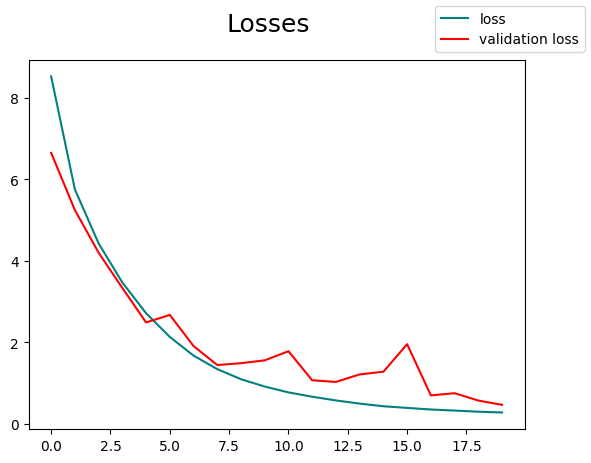

In [37]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="red", label="validation loss")
fig.suptitle("Losses", fontsize=18)
fig.legend(loc="upper right")
plt.show()

## save and load the actual final model

### According to a bug in Tensorflow 2.10, models can not be saved with the common function. Saving weights seperatly and then loading it to the defined architecture 

In [65]:
final_model.save_weights("./model_params/car_body_params/trial_00/weights.h5")

In [10]:
with open("./model_params/car_body_params/trial_00/trial.json", 'r') as file:
    trials_data = json.load(file)

hyperparameters = trials_data['hyperparameters']['values']
learning_rate = hyperparameters['learning_rate']
batch_size = hyperparameters['batch_size']
dropout_rate = hyperparameters['dropout_rate']
dense_neurons = hyperparameters['dense_neurons']
regularization_l = hyperparameters['regularization_l']

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling='max')
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(dense_neurons, kernel_regularizer=tf.keras.regularizers.l2(l=regularization_l),
          activity_regularizer=tf.keras.regularizers.l1(regularization_l),
          bias_regularizer=tf.keras.regularizers.l1(regularization_l), activation='relu')(x)
x = Dropout(rate=dropout_rate, seed=42)(x)
output = Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = Adamax(learning_rate=learning_rate)
model.load_weights("./model_params/car_body_params/trial_00/weights.h5")
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
model.evaluate(test_set)

 8/55 [===>..........................] - ETA: 32s - loss: 0.3541 - accuracy: 0.9297

d:\anaconda3\envs\tf_env\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


55/55 [==============================] - 75s 770ms/step - loss: 0.8870 - accuracy: 0.7557


[0.8869886994361877, 0.7556947469711304]

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']      

### make some testing predictions 

1/1 [==============================] - 31s 31s/step


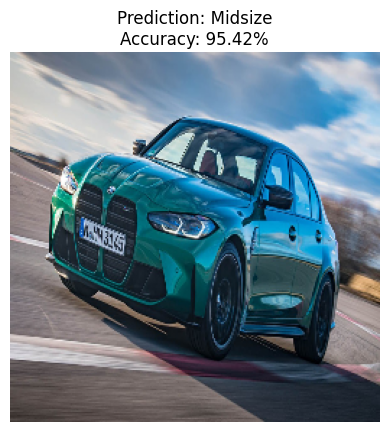

In [16]:
image_path = './fahrbericht-bmw-m3-m4-2.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))  
image = image / 255.0  

image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
predicted_class_index = np.argmax(predictions, axis=1)

class_labels = ['Large', 'Midsize', 'Small']
predicted_class_label = class_labels[predicted_class_index[0]]

accuracy = predictions[0][predicted_class_index[0]] * 100

plt.imshow(image[0])
plt.title('Prediction: {}\nAccuracy: {:.2f}%'.format(predicted_class_label, accuracy))
plt.axis('off')
plt.show()
